In [48]:
import sys
print(sys.executable)
print(sys.version)

c:\Users\antit\miniconda3\envs\qiskit1_env\python.exe
3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]


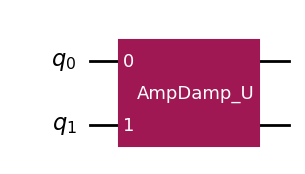

In [ ]:
from qiskit.circuit.library import UnitaryGate
from qiskit import transpile
from qiskit import QuantumCircuit
import numpy as np
target_fidelity = .85
gamma = 1 - (2*np.sqrt(target_fidelity) - 1)**2  # For Bell state under damping
sqrt_g = np.sqrt(gamma)
sqrt_1g = np.sqrt(1 - gamma)


# Basis: |00>, |01>, |10>, |11> with qubit1 (target) and qubit2 (ancilla)
U = np.array([
    [1, 0,         0,       0],
    [0, sqrt_1g,   sqrt_g,  0],
    [0, -sqrt_g,   sqrt_1g, 0],
    [0, 0,         0,       1]
])
U =UnitaryGate(U, label="AmpDamp_U")
U2 = QuantumCircuit(2)
U2.compose(U, [0,1], inplace=True)
#qc2 = transpile(U2, basis_gates=['r', 'cz'], optimization_level=3)
U2.draw('mpl')

In [2]:
from qiskit.circuit.library import UnitaryGate
import numpy as np
from importlib import reload
import unitary_test
reload(unitary_test)
from unitary_test import depol_U_8x8, p_from_target_fidelity, depol_stinespring
target_fidelity = .85
depol_U_bool = False
depol_Pauli_bool = False
depol_QPD = True
if depol_U_bool:
    p = p_from_target_fidelity(target_fidelity)
    U = UnitaryGate(depol_U_8x8(p), label="Depol")
        
elif depol_Pauli_bool:
    p = (4/3)*p_from_target_fidelity(target_fidelity)
    dep_gate = depol_stinespring(p)
        


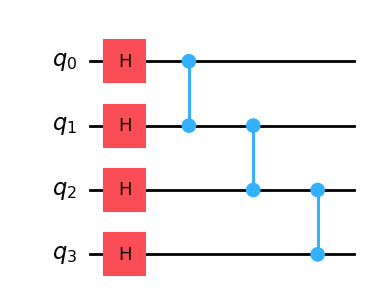

In [3]:
#This builds a linear graph state 0-1-2-3
from qiskit import QuantumCircuit

def make_base_graph():
    qc = QuantumCircuit(4)
    for q in [0,1,2,3]:
        qc.h(q)  
    #qc.cz(3,0)
    for a, b in [(0,1),(1,2),(2,3)]:
        qc.cz(a,b)
    # leave out cz(0,3) here – we’ll insert it via the three methods
    return qc

qc_real = make_base_graph()
qc_real.draw('mpl')

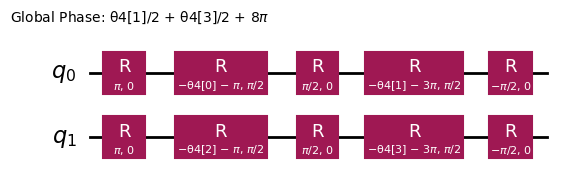

In [4]:
#This builds the cut bell pair factory for one cut bell pair
from qiskit import qpy
from qiskit import transpile
with open("data/one_bell_pair.qpy", "rb") as fd:
    cut_bell_pair_factory1 = qpy.load(fd)[0]
if depol_U_bool:
    cut_bell_pair_factory = QuantumCircuit(6)

    cut_bell_pair_factory.compose(cut_bell_pair_factory1,[2,3], inplace = True)
    cut_bell_pair_factory.compose(U,[2,1,0], inplace = True)
    cut_bell_pair_factory.compose(U,[3,4,5], inplace = True)
elif depol_Pauli_bool:
    cut_bell_pair_factory = QuantumCircuit(8)
    cut_bell_pair_factory.compose(cut_bell_pair_factory1,[3,4], inplace = True)
    cut_bell_pair_factory.compose(dep_gate,[3,0,1,2], inplace=True)
    cut_bell_pair_factory.compose(dep_gate,[4,5,6,7], inplace=True)
else: 
    cut_bell_pair_factory = QuantumCircuit(2)

    cut_bell_pair_factory.compose(cut_bell_pair_factory1,[0,1], inplace = True)

#cut_bell_pair_factory.draw("mpl", fold=False)

qc2 = transpile(cut_bell_pair_factory, basis_gates=['r', 'cz'], optimization_level=3)
qc2.draw('mpl')

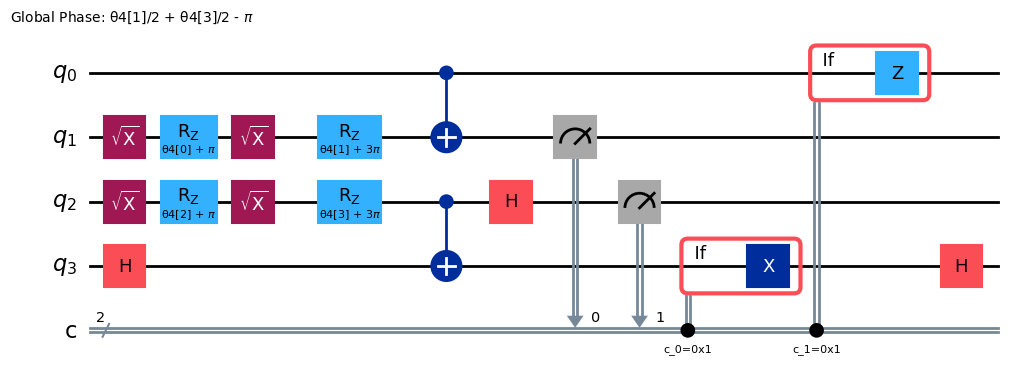

In [5]:
#This puts the cut bell pair factory in a teleportation circuit
if depol_U_bool:
    teleportation_circuit = QuantumCircuit(8,2)
elif depol_Pauli_bool:
    teleportation_circuit = QuantumCircuit(10,2)
else:
    teleportation_circuit = QuantumCircuit(4,2)
#teleportation_circuit.h(2)
#teleportation_circuit.h(1)
#teleportation_circuit.h(0)
#teleportation_circuit.h(3)
teleportation_circuit.h(3)
if depol_U_bool:
    teleportation_circuit.compose(cut_bell_pair_factory,[4,5,1,2,6,7],inplace=True)
elif depol_Pauli_bool:
    teleportation_circuit.compose(cut_bell_pair_factory,[4,5,6,1,2,7,8,9],inplace=True)
else: 
    teleportation_circuit.compose(cut_bell_pair_factory,[1,2],inplace=True)
#teleportation_circuit.h(3)
teleportation_circuit.cx(0,1)
teleportation_circuit.cx(2,3)
teleportation_circuit.h(2)
teleportation_circuit.measure(1,0)
teleportation_circuit.measure(2,1)
with teleportation_circuit.if_test((teleportation_circuit.clbits[1],1)):
    teleportation_circuit.z(0)
with teleportation_circuit.if_test((teleportation_circuit.clbits[0],1)):
    teleportation_circuit.x(3)
teleportation_circuit.h(3)

teleportation_circuit.draw('mpl')

In [6]:
# now put the cut bell pair into the graph state 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_aer import AerSimulator
if depol_U_bool:
    cut_graph_state = QuantumCircuit(10,2)
elif depol_Pauli_bool:
    cut_graph_state = QuantumCircuit(12,2)
else: 
    cut_graph_state = QuantumCircuit(6,2)
cut_graph_state.compose(qc_real, [0,1,2,3], inplace=True)
if depol_U_bool:
    cut_graph_state.compose(teleportation_circuit, [0,4,5,3,6,7,8,9], [0,1], inplace=True)
elif depol_Pauli_bool:
    cut_graph_state.compose(teleportation_circuit, [0,4,5,3,6,7,8,9,10,11], [0,1], inplace=True)
else: 
    cut_graph_state.compose(teleportation_circuit, [0,4,5,3], [0,1], inplace=True)
#cut_graph_state.draw('mpl')
#service = QiskitRuntimeService() 
#backend1 = service.backend("ibm_torino")
#tc = transpile(cut_graph_state, backend=backend1, optimization_level=3)
#tc.draw('mpl')









In [ ]:
#Only run this once girl!!!!!!!!!!!
from qiskit_ibm_runtime import QiskitRuntimeService
token = "wNB6gtFL0wobt8rFze6UGZp6dLfGRw0nDr2nb1eJHM8x"

QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_cloud", # `channel` distinguishes between different account types.
  instance="crn:v1:bluemix:public:quantum-computing:us-east:a/864c2f593f7d456d815b632b2d616667:714b70bd-14f6-4774-8981-e5ccb9dc6664::", # Optionally copy the instance CRN or name from the Instance section on the dashboard.
  overwrite=True # Only needed if you already have Cloud credentials.
)

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
#from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
import numpy as np
from qiskit_aer.noise import NoiseModel

from qiskit.quantum_info import SparsePauliOp

import qiskit_aer; print(qiskit_aer.__version__)

def pauli_string(num_qubits, terms):
    s = ["I"] * num_qubits
    for op, idx in terms:
        s[idx] = op
    return ''.join(reversed(s))

num_qubits = 6

# ---- load QPD parameter tuples ----
thetas = np.loadtxt("cut_graph_state_data/data/one_qpd_bell_pair_param_values.txt")
I_LOCC = len(thetas)

# Build strings
#S0_str = pauli_string(num_qubits, [("Z", 2), ("Z", 4), ("X", 5)])
#S3_str = pauli_string(num_qubits, [("X", 2), ("Z", 3), ("Z", 5)])

# Turn into observables
#observables = {
    #"S0": SparsePauliOp.from_list([(S0_str, 1.0)]),
    #"S3": SparsePauliOp.from_list([(S3_str, 1.0)]),
#}
#observables["S03"] = observables["S0"].dot(observables["S3"])

S0_label  = pauli_string(num_qubits, [("X",0), ("Z",1), ("Z",3)])
# S3 = X3 Z0 Z2
S3_label  = pauli_string(num_qubits, [("X", 3,), ("Z",0), ("Z",2)])
print(S0_label)
observables = {
    "S0":  SparsePauliOp.from_sparse_list([("ZZX", [3,1,0], 1)], num_qubits=6),
    "S3":  SparsePauliOp.from_sparse_list([("ZZX", [0,2,3], 1)], num_qubits=6),
    "S03": SparsePauliOp.from_sparse_list([("YZZY", [0,1,2,3], 1)], num_qubits=6)
}

# Setup simulator and transpile circuit
#run on real noise model
service = QiskitRuntimeService()
hw = service.backend("ibm_torino")

# 2) Aer simulator with Torino noise (keeps dynamics by NOT copying coupling_map)
noise = NoiseModel.from_backend(hw)
backend = AerSimulator(
    noise_model=noise,
    basis_gates=noise.basis_gates,
    coupling_map=None,          # keep dynamic-circuit-friendly
)
qct = transpile(cut_graph_state,backend, scheduling_method="asap")
layout=qct.layout
observables["S0"] = observables["S0"].apply_layout(layout)
observables["S3"] = observables["S0"].apply_layout(layout)
observables["S03"] = observables["S0"].apply_layout(layout)
exact_estimator = Estimator.from_backend(backend, options={ "run_options": {"shots": 1024}})
#exact_estimator = Estimator(backend, options={"default_shots": 1024, "resilience_level": 0})
#exact_estimator.options.default_shots = 2000

print(type(exact_estimator))          # should show qiskit_aer.primitives.EstimatorV2 (or Estimator)
print(type(backend))

#base = QuantumCircuit(6, 6)
#base.compose(cut_graph_state, [0, 1, 2, 3, 4, 5], [0, 1], inplace=True)

isa_circuit = pass_manager.run(qct)
#print(thetas.shape)  # should be (I_LOCC, 4)
#print(type(thetas[0]), thetas[0])  # <class 'numpy.ndarray'> [t0, t1, t2, t3]


# Prepare results data structure
results_dict = {}

for i in range(I_LOCC):
    theta = thetas[i]
    print(i)
    results_dict[i] = {}

    params = list(isa_circuit.parameters)
    bind_map = dict(zip(params, theta))
    bound = isa_circuit.assign_parameters(bind_map, inplace=False)
    
    for label, observable in observables.items():
        pub = (isa_circuit, observable, theta)
        job = exact_estimator.run([pub])
        result = job.result()
        exact_value = float(result[0].data.evs)
        variance = (result[0].data.stds)
        results_dict[i][label] = exact_value
        print("label", label, exact_value, variance)
    


0.17.0
IIZIZX
<class 'qiskit_aer.primitives.estimator_v2.EstimatorV2'>
<class 'qiskit_aer.backends.aer_simulator.AerSimulator'>
0
label S0 0.9511720362949614 0.0
label S3 0.9482421402720326 0.0
label S03 0.9501952097794044 0.0
1
label S0 0.23163345024504728 0.0
label S3 0.23508612242540866 0.0
label S03 0.23742757458699115 0.0
2
label S0 0.23435722427813302 0.0
label S3 0.2360621391599818 0.0
label S03 0.2322228185625307 0.0
3
label S0 1.0354727152573028e-07 0.0
label S3 -1.2801636444166727e-07 0.0
label S03 1.0656976643851455e-09 0.0
4
label S0 1.0525455236176355e-07 0.0
label S3 -4.878758182780865e-10 0.0
label S03 -1.0432639089595143e-07 0.0
5
label S0 -3.1208217596833095e-07 0.0
label S3 -5.113407559054777e-10 0.0
label S03 -0.0009767932916795964 0.0
6
label S0 -2.3074610933525966e-07 0.0
label S3 -5.452509940239028e-07 0.0
label S03 -7.772320930176184e-10 0.0


In [8]:
# Target: F = 0.85  ->  μ = (4F-1)/3 = 0.80
target_fidelity = .85
mu = (4*target_fidelity -1) / 3 

expect_bell = {label: 0.0 for label in next(iter(results_dict.values())).keys()}
expect_id   = {label: 0.0 for label in next(iter(results_dict.values())).keys()}
expect      = {label: 0.0 for label in next(iter(results_dict.values())).keys()}

# both masks are {0,1,2} since we measured 3 classical bits [b2,b1,b0]


for i, result in results_dict.items():
    for label in result:
        if i < 3:
            expect_bell[label] += (2/9) * result[label]
        elif i < 5:
            expect_bell[label] += (-1/6) * result[label]
        if depol_QPD and i in (3, 4, 5, 6):
            expect_id[label] += 0.25 * result[label]

for label in expect:
    if depol_QPD:
        expect[label] = mu * (3.0 * expect_bell[label]) + (1.0 - mu) * expect_id[label]
    else:
        expect[label] = 3 * expect_bell[label]

# 6) Final entanglement witness = ⟨S0⟩ + ⟨S3⟩

print(f"⟨S0⟩ = {expect['S0']:.5f}")
print(f"⟨S3⟩ = {expect['S3']:.5f}")
print(f"⟨S03⟩ = {expect['S03']:.5f}")
witness = (1-expect['S3']-expect['S0']-expect['S03'])/4.0
print(f"Entanglement witness = {witness:.5f}")

⟨S0⟩ = 0.75582
⟨S3⟩ = 0.75701
⟨S03⟩ = 0.75720
Entanglement witness = -0.31751
